# Movie Genre Predictor

Importing Libraries

In [93]:
import tensorflow as tf
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize 
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM,Dropout,Activation,Bidirectional,Embedding,Dense,Flatten,GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint
import os
from gensim.models import Word2Vec, KeyedVectors
import tensorflow_hub as hub
from tensorflow.keras.regularizers import l2

Tensorflow Version is 2.3

In [30]:
from google.colab import drive
drive.mount('/content/gdrive')
tf.__version__

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


'2.6.0'

Now Reading the data in CSV format through Pandas

In [31]:
movies=pd.read_csv('/content/gdrive/MyDrive/wiki_movie_plots_deduped.csv')
# movies=pd.read_csv('wiki_movie_plots_deduped.csv')
movies.head()

,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,1901,Kansas Saloon Smashers,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Kansas_Saloon_Sm...,"A bartender is working at a saloon, serving dr..."
1,1901,Love by the Light of the Moon,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/Love_by_the_Ligh...,"The moon, painted with a smiling face hangs ov..."
2,1901,The Martyred Presidents,American,Unknown,NaN,unknown,https://en.wikipedia.org/wiki/The_Martyred_Pre...,"The film, just over a minute long, is composed..."
3,1901,"Terrible Teddy, the Grizzly King",American,Unknown,NaN,unknown,"https://en.wikipedia.org/wiki/Terrible_Teddy,_...",Lasting just 61 seconds and consisting of two ...
4,1902,Jack and the Beanstalk,American,"George S. Fleming, Edwin S. Porter",NaN,unknown,https://en.wikipedia.org/wiki/Jack_and_the_Bea...,The earliest known adaptation of the classic f...


# Organizing Genre colunm for target Values


Now we are only predicting horror,drama,comedy and action so filtering them out

In [32]:
MainGenres=['drama','comedy','action','horror']
movies=movies[movies['Genre'].isin(MainGenres)]
len(movies)

12608

In [33]:
movies=movies.reset_index()
movies.head(5)

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...


Now assigning id's to our genres according to GenreCoreected colunm

In [34]:
movies['GenreID']=movies['Genre'].apply(lambda x:MainGenres.index(x))
movies.head(10)

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,0
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,0
5,18,1908,A Calamitous Elopement,American,D.W. Griffith,"Harry Solter, Linda Arvidson",comedy,https://en.wikipedia.org/wiki/A_Calamitous_Elo...,A young couple decides to elope after being ca...,1
6,20,1908,A Christmas Carol,American,Unknown,Tom Ricketts,drama,https://en.wikipedia.org/wiki/A_Christmas_Caro...,No prints of the first American film adaptatio...,0
7,22,1909,At the Altar,American,D. W. Griffith,Marion Leonard,drama,https://en.wikipedia.org/wiki/At_the_Altar,A rejected admirer sets up a trap to kill his ...,0
8,23,1909,A Drunkard's Reformation,American,D. W. Griffith,Arthur V. Johnson,drama,https://en.wikipedia.org/wiki/A_Drunkard%27s_R...,"John Wharton, the husband of a true and trusti...",0
9,24,1909,The Golden Louis,American,D. W. Griffith,NaN,drama,https://en.wikipedia.org/wiki/The_Golden_Louis,An old woman sends a girl begging in the stree...,0


Now Checking Individual Genre Record

In [35]:
no_drama=movies['Genre'].str.contains('drama').sum()
no_comedy=movies['Genre'].str.contains('comedy').sum()
no_horror=movies['Genre'].str.contains('horror').sum()
no_action=movies['Genre'].str.contains('action').sum()
print("Number of Drama movies:",no_drama)
print("Number of Comedy movies:",no_comedy)
print("Number of Horror movies:",no_horror)
print("Number of Action movies:",no_action)

Number of Drama movies: 5964
Number of Comedy movies: 4379
Number of Horror movies: 1167
Number of Action movies: 1098


Showing Values in Bar chart

[Text(0.5, 0, 'Genre'), Text(0.5, 1.0, 'Genre Counnt')]

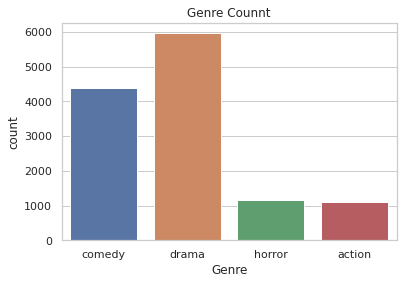

In [36]:
import seaborn as sns
sns.set(style='whitegrid')
figsize=(18, 6)
ax=sns.countplot(x=movies['Genre'], data=movies)
ax.set(xlabel='Genre',title="Genre Counnt")

# Plot Summaries Pre-Processing

In [37]:
import random
synNumber=random.randint(1,1000)
print(movies['Title'].loc[synNumber])
print(movies['Genre'].loc[synNumber])
print(movies['Plot'].loc[synNumber])

The Red Dance
drama
Tasia (Dolores del Río), a beautiful dancer lower class of Russia, falls heir to the throne Prince, Grand Duke Eugene (Charles Farrell), but only admired from a distance. At the outbreak of the Russian Revolution, the Duke falls in captivity and this allows Tasia be near him.


In [38]:
def  clean_text(df, text_field, new_text_field_name):
    df[new_text_field_name] = df[text_field].str.lower()
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?", "", elem))  
    # remove numbers
    df[new_text_field_name] = df[new_text_field_name].apply(lambda elem: re.sub(r"\d+", "", elem))
    
    return df

In [39]:
data_clean = clean_text(movies, 'Plot', 'Plot_clean')
data_clean.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,the film is about a family who move to the sub...
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1,before heading out to a baseball game at a nea...
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1,the plot is that of a black woman going to the...
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,0,on a beautiful summer day a father and mother ...
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,0,a thug accosts a girl as she leaves her workpl...


In [40]:
nltk.download('stopwords')
nltk.download('punkt')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
# plots=data_clean['Plot_clean'].values

In [42]:
# vec=[word_tokenize(plot)for plot in plots]

In [43]:
# modelvec=Word2Vec(vec,min_count=1)

In [44]:
# word_embeddings=KeyedVectors.load_word2vec_format('/content/gdrive/MyDrive/GoogleNews-vectors-negative300.bin',binary=True)

In [45]:
# stemmer = PorterStemmer()
# def stem_words(text):
#     return " ".join([stemmer.stem(word) for word in text.split()])

# data_clean["Plot_clean"] = data_clean["Plot_clean"].apply(lambda text: stem_words(text))
# data_clean.head()

In [46]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in text.split()])

In [47]:
nltk.download('wordnet')
data_clean["Plot_clean"] = data_clean["Plot_clean"].apply(lambda text: lemmatize_text(text))
data_clean.head()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,the film is about a family who move to the sub...
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1,before heading out to a baseball game at a nea...
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1,the plot is that of a black woman going to the...
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,0,on a beautiful summer day a father and mother ...
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,0,a thug accosts a girl a she leaf her workplace...


In [48]:
data_clean['Plot_clean'] = data_clean['Plot_clean'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
data_clean.head()

,index,Release Year,Title,Origin/Ethnicity,Director,Cast,Genre,Wiki Page,Plot,GenreID,Plot_clean
0,7,1904,The Suburbanite,American,Wallace McCutcheon,NaN,comedy,https://en.wikipedia.org/wiki/The_Suburbanite,The film is about a family who move to the sub...,1,film family move suburb hoping quiet life thin...
1,14,1907,How Brown Saw the Baseball Game,American,Unknown,Unknown,comedy,https://en.wikipedia.org/wiki/How_Brown_Saw_th...,Before heading out to a baseball game at a nea...,1,heading baseball game nearby ballpark sport fa...
2,15,1907,Laughing Gas,American,Edwin Stanton Porter,"Bertha Regustus, Edward Boulden",comedy,https://en.wikipedia.org/wiki/Laughing_Gas_(fi...,The plot is that of a black woman going to the...,1,plot black woman going dentist toothache given...
3,16,1908,The Adventures of Dollie,American,D. W. Griffith,"Arthur V. Johnson, Linda Arvidson",drama,https://en.wikipedia.org/wiki/The_Adventures_o...,On a beautiful summer day a father and mother ...,0,beautiful summer day father mother take daught...
4,17,1908,The Black Viper,American,D. W. Griffith,D. W. Griffith,drama,https://en.wikipedia.org/wiki/The_Black_Viper,A thug accosts a girl as she leaves her workpl...,0,thug accosts girl leaf workplace man rescue th...


Tokenizing and creating and padding the sequences

In [49]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts((list(data_clean['Plot_clean'])))
sequences=tokenizer.texts_to_sequences((list(data_clean['Plot_clean'])))
word_index=tokenizer.word_index
print("unique tokens:",len(word_index))
max_len=np.max([len(sequence) for sequence in sequences])
print("Max length:",max_len)
data = pad_sequences(sequences, maxlen=max_len)
print("Shape of data tensor:",data.shape)

unique tokens: 114645
Max length: 1488
Shape of data tensor: (12608, 1488)


Making Target labels to Categorical

In [50]:
labels=np.asarray(movies['GenreID'])
labels=to_categorical(labels,num_classes=4)
print('Label:',labels.shape)
labels

Label: (12608, 4)


array([[0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.]], dtype=float32)

In [51]:
# embedding_dim=300
# total_words=len(word_index)+1
# skipped_words=0
# embedding_vector=None
# embedding_matrix=np.zeros((total_words,embedding_dim))
# for word,index in tokenizer.word_index.items():
#     try:
#         embedding_vector=wordembeddings[word]
#     except:
#         skipped_words-skipped_words+1
#         pass
#     if embedding_vector is not None:
#         embedding_matrix[index]=embedding_vector
# print("Embeddings Matrix Shape :",embedding_matrix.shape)

In [52]:
# Embedding_layer=Embedding(total_words,embedding_dim,weights=[embedding_matrix],input_length=max_len,trainable=False)

# Creating a Model

In [107]:
#splitting the data for training testing and validation
# training_samples=11000
# validation_samples=3000
# X_train=data[:training_samples]
# y_train=labels[:training_samples]
# X_val=data[training_samples:training_samples+validation_samples]
# y_val=labels[training_samples:training_samples+validation_samples]
X_train,X_val,y_train,y_val=train_test_split(data,labels,test_size=0.15,random_state=42)
shuffle_index=np.random.permutation(len(X_train))
X_train,y_train=X_train[shuffle_index],y_train[shuffle_index]

In [132]:
embedding_dim=700
model=Sequential()
model.add(Embedding(input_dim=len(word_index)+1,output_dim=embedding_dim,input_length=max_len))
model.add(Dropout(0.2))
# model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
# model.add(Dropout(0.3))
model.add(LSTM(100,kernel_regularizer=l2(0.0001),return_sequences=True))
model.add(Dropout(0.4))
model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.6))
# model.add(Dense(32, activation='relu'))
# model.add(Dropout(0.6))
model.add(Dense(4, activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(learning_rate=1e-3),metrics=['categorical_accuracy'])
model.summary()
# 32,kernel_regularizer=l2(0.001),input_shape=(X_train.shape[1:]),activation='tanh'

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_17 (Embedding)     (None, 1488, 700)         80252200  
_________________________________________________________________
dropout_48 (Dropout)         (None, 1488, 700)         0         
_________________________________________________________________
lstm_22 (LSTM)               (None, 1488, 100)         320400    
_________________________________________________________________
dropout_49 (Dropout)         (None, 1488, 100)         0         
_________________________________________________________________
flatten_16 (Flatten)         (None, 148800)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 4)                 595204    
Total params: 81,167,804
Trainable params: 81,167,804
Non-trainable params: 0
_________________________________________

In [133]:
filepath="MovieGenrePredictionUsingPlotSummariesmodel1.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=True)
callbacks_list = [checkpoint]
len(X_train),len(X_val)

(10716, 1892)

In [134]:
history=model.fit(X_train,y_train, epochs=5, callbacks=callbacks_list, batch_size=128, validation_data=(X_val,y_val))

Epoch 1/5
84/84 [==============================] - 51s 585ms/step - loss: 1.0053 - categorical_accuracy: 0.5833 - val_loss: 0.6969 - val_categorical_accuracy: 0.7209
Epoch 2/5
84/84 [==============================] - 49s 580ms/step - loss: 0.3350 - categorical_accuracy: 0.8890 - val_loss: 0.7873 - val_categorical_accuracy: 0.7199
Epoch 3/5
84/84 [==============================] - 49s 579ms/step - loss: 0.0947 - categorical_accuracy: 0.9812 - val_loss: 1.1348 - val_categorical_accuracy: 0.7077
Epoch 4/5
84/84 [==============================] - 49s 579ms/step - loss: 0.0515 - categorical_accuracy: 0.9947 - val_loss: 1.2328 - val_categorical_accuracy: 0.7125
Epoch 5/5
84/84 [==============================] - 49s 579ms/step - loss: 0.0396 - categorical_accuracy: 0.9977 - val_loss: 1.4695 - val_categorical_accuracy: 0.7151


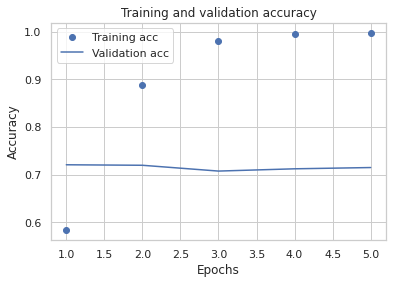

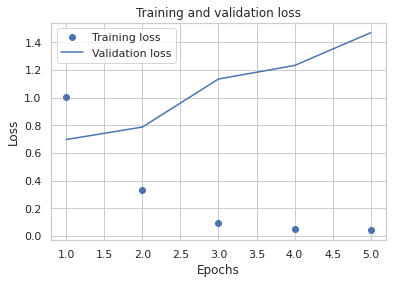

In [135]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(1,len(acc)+1)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [136]:
from sklearn.metrics import accuracy_score

pred = model.predict(X_val)
predict_classes = np.argmax(pred,axis=1)
expected_classes = np.argmax(y_val,axis=1)
correct = accuracy_score(expected_classes,predict_classes)
print(f"Accuracy: {correct}")

Accuracy: 0.7151162790697675


In [137]:
from tensorflow.python.keras.models import load_model

best_model = load_model('MovieGenrePredictionUsingPlotSummariesmodel1.h5')

In [138]:
batch_size=128
steps_test=int(len(X_val)/batch_size)
result = best_model.evaluate(X_val, y_val, steps=steps_test,verbose=1)
print("Validation-set accuracy: {0:.2%}".format(result[1]))

14/14 [==============================] - 3s 173ms/step - loss: 0.6969 - categorical_accuracy: 0.7209
Validation-set accuracy: 72.09%


In [139]:
best_model.save('fypmodel{:.2%}.h5'.format(result[1]))
name='fypmodel{:.2%}.tflite'.format(result[1])
converter = tf.lite.TFLiteConverter.from_keras_model(best_model) # path to the SavedModel directory
tflite_model = converter.convert()

# Save the model.
with open(name, 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp1gm0re0v/assets


INFO:tensorflow:Assets written to: /tmp/tmp1gm0re0v/assets


In [144]:
preds = best_model.predict(X_val, batch_size=128,verbose=1)
preds=np.around(preds)

orig_val_labels=np.argmax(y_val,axis=1)
predicted_labels=np.argmax(preds,axis=1)

orig_val_labels=np.reshape(orig_val_labels,(len(X_val),1))
predicted_labels=np.reshape(predicted_labels,(len(X_val),1))

print(predicted_labels.shape)
print(orig_val_labels.shape)

15/15 [==============================] - 2s 154ms/step
(1892, 1)
(1892, 1)


<Figure size 432x288 with 0 Axes>

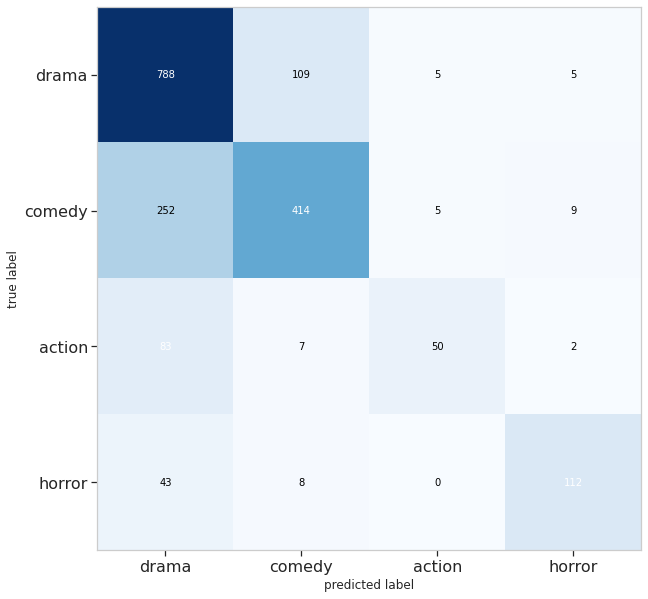

In [145]:
%matplotlib inline
# Get the confusion matrix
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

cm  = confusion_matrix(orig_val_labels, predicted_labels)
plt.figure()
plot_confusion_matrix(cm,figsize=(15,10), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.yticks(range(4), ['drama','comedy','action','horror'], fontsize=16)
plt.show()

In [146]:
# calculates precision for 1:100 dataset with 90 tp and 30 fp
from sklearn.metrics import precision_score
precision = precision_score(orig_val_labels,predicted_labels,average='micro')
print('Precision: %.3f' % precision)

Precision: 0.721


In [147]:
print(classification_report(orig_val_labels,predicted_labels,target_names=MainGenres))

              precision    recall  f1-score   support

       drama       0.68      0.87      0.76       907
      comedy       0.77      0.61      0.68       680
      action       0.83      0.35      0.50       142
      horror       0.88      0.69      0.77       163

    accuracy                           0.72      1892
   macro avg       0.79      0.63      0.68      1892
weighted avg       0.74      0.72      0.71      1892

